In [26]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.5 MB/s            


In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco","idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()

print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv =10, return_train_score = False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao)*100))

Accuracy com dummy stratified, 10 = [73.83, 77.73]


In [5]:
# gerando dados aleatorios de modelo de carro para simulado de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo - dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,16
1,40557.96,1,20,12622.05362,22
2,89627.50,0,12,11440.79806,12
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,3


In [6]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio: %.2f" % media)
    print("Intervalo [%.2f, %.2f]" %( media - 2 * desvio, media + 2 * desvio ))

In [7]:
# GroupKFols em um pipeline com StandardScaler e SVC
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao', scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio: 76.68
Intervalo [74.28, 79.08]


In [7]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Na validação cruzada treinamos para saber quão bom seria nosso modelo no mundo real
from sklearn.model_selection import GroupKFold
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = False)
imprime_resultados(results) 

Accuracy médio: 75.78
Intervalo [73.67, 77.90]


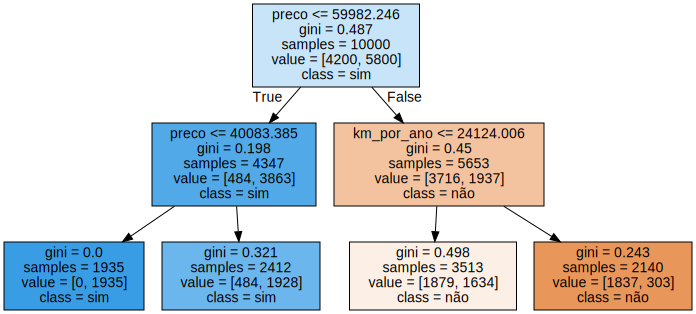

In [8]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data=export_graphviz(modelo, out_file=None, filled=True, class_names=["não","sim"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Testando parâmetros

In [9]:
def roda_arvore_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, test = %.2f" % (max_depth, train_score, test_score ))
    tabela = [max_depth, train_score, test_score]
    return tabela

resultados = [roda_arvore_decisao(i) for i in range(1, 33)]#33 exclusive 32 inclusivo  
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, test = 75.78
Arvore max_depth = 2, treino = 75.79, test = 75.78
Arvore max_depth = 3, treino = 78.75, test = 78.67
Arvore max_depth = 4, treino = 78.79, test = 78.63
Arvore max_depth = 5, treino = 78.94, test = 78.56
Arvore max_depth = 6, treino = 79.17, test = 78.12
Arvore max_depth = 7, treino = 79.50, test = 77.96
Arvore max_depth = 8, treino = 79.89, test = 77.86
Arvore max_depth = 9, treino = 80.46, test = 77.38
Arvore max_depth = 10, treino = 81.16, test = 77.19
Arvore max_depth = 11, treino = 82.03, test = 76.97
Arvore max_depth = 12, treino = 82.89, test = 76.49
Arvore max_depth = 13, treino = 83.95, test = 75.81
Arvore max_depth = 14, treino = 85.03, test = 75.66
Arvore max_depth = 15, treino = 86.14, test = 75.16
Arvore max_depth = 16, treino = 87.19, test = 75.11
Arvore max_depth = 17, treino = 88.31, test = 74.74
Arvore max_depth = 18, treino = 89.26, test = 74.33
Arvore max_depth = 19, treino = 90.32, test = 74.34
Arvore max_depth = 20

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


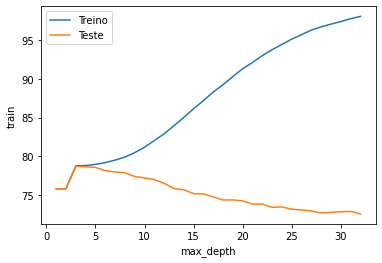

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino","Teste"])


In [12]:
resultados.sort_values("test", ascending=False).head() #OVERFIT

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


# Explorando hiper parâmetros em 2 dimensões

In [13]:
def roda_arvore_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %.d, treino = %.2f, test = %.2f" % (max_depth, min_samples_leaf, train_score, test_score ))
    tabela = [max_depth, min_samples_leaf , train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train","test"])
    return resultados
 
resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, test = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, test = 78.67
Arvore max_depth = 4, min_sample

Arvore max_depth = 28, min_samples_leaf = 64, treino = 79.79, test = 77.30
Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.89, test = 76.84
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.79, test = 77.30
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.89, test = 76.84
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.79, test = 77.30
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.89, test = 76.84
Arvore max_depth = 31, min_samples_leaf = 64, treino = 79.79, test = 77.30
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [14]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [15]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


<AxesSubplot:>

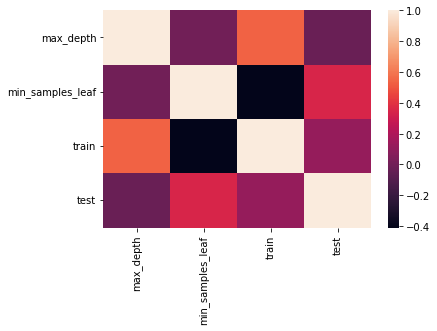

In [16]:
sns.heatmap(corr, )

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

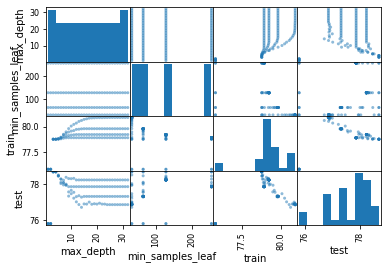

In [21]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

pd.plotting.scatter_matrix(resultados)

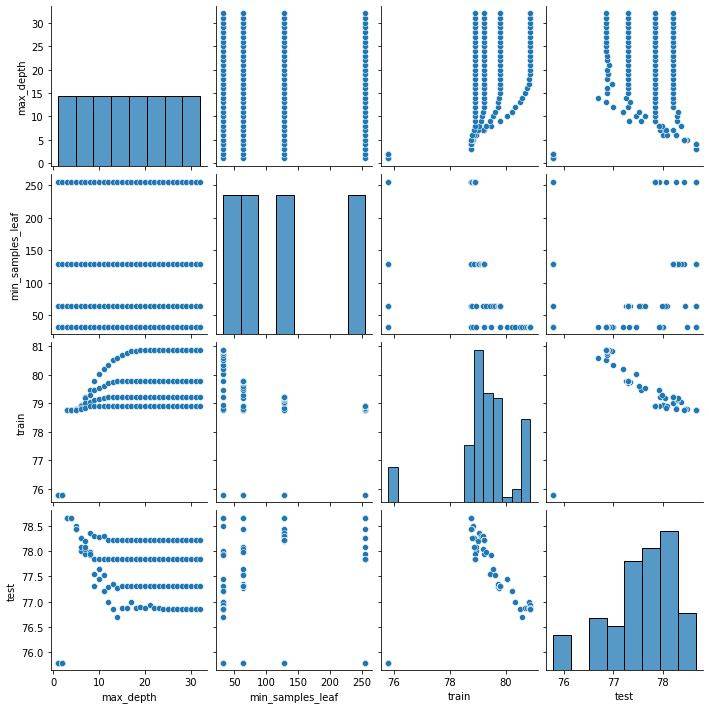

In [22]:
sns.pairplot(resultados)

<AxesSubplot:>

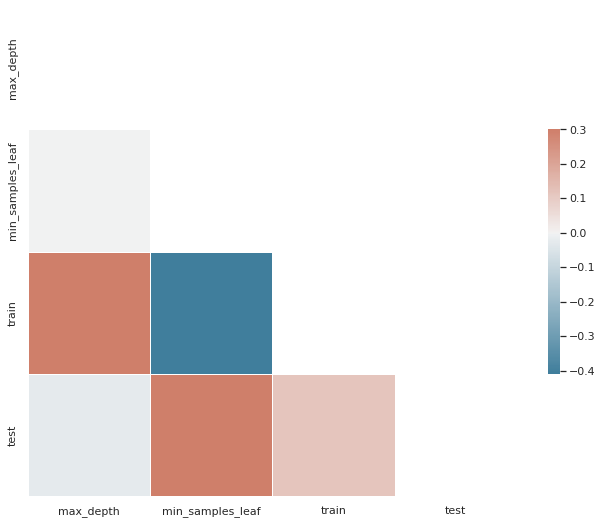

In [25]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, test = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, test = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, test = 78.67
Arvore max_depth = 4, min

Arvore max_depth = 28, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 28, min_samples_leaf = 512, treino = 77.53, test = 77.50
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 29, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 29, min_samples_leaf = 512, treino = 77.53, test = 77.50
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 30, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 30, min_samples_leaf = 512, treino = 77.53, test = 77.50
Arvore max_depth = 31, min_samples_leaf = 128, treino = 79.21, test = 78.22
Arvore max_depth = 31, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [29]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


In [30]:

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [192, 216, 236, 256]:
            tabela = roda_arvore_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 216, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 236, treino = 75.79, test = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 216, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 236, treino = 75.79, test = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, test = 75.78
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 216, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 236, treino = 78.75, test = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, test = 78.67
Arvore max_depth = 4, min_samples_leaf = 192, treino = 78.75, test = 78.67
Arvore max_depth = 4, min

Arvore max_depth = 28, min_samples_leaf = 216, treino = 78.99, test = 77.84
Arvore max_depth = 28, min_samples_leaf = 236, treino = 78.94, test = 77.84
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 29, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 29, min_samples_leaf = 216, treino = 78.99, test = 77.84
Arvore max_depth = 29, min_samples_leaf = 236, treino = 78.94, test = 77.84
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 30, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 30, min_samples_leaf = 216, treino = 78.99, test = 77.84
Arvore max_depth = 30, min_samples_leaf = 236, treino = 78.94, test = 77.84
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.90, test = 77.85
Arvore max_depth = 31, min_samples_leaf = 192, treino = 79.01, test = 78.05
Arvore max_depth = 31, min_samples_leaf = 216, treino = 78.99, test = 77.84
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,192,75.791169,75.784219
1,1,216,75.791169,75.784219
2,1,236,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,192,75.791169,75.784219


<AxesSubplot:>

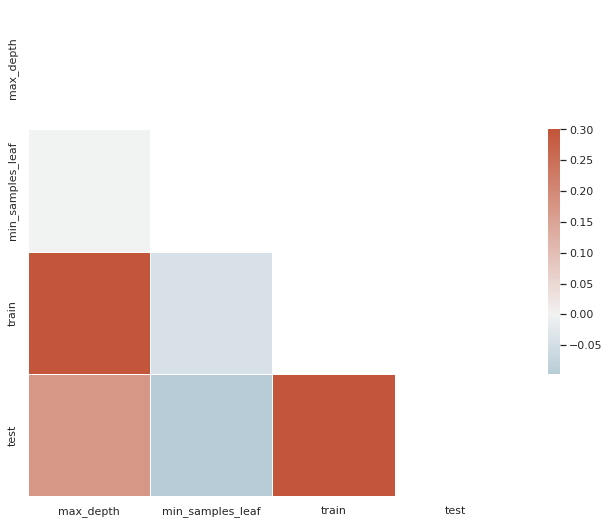

In [32]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = resultados.corr()
sns.set_theme(style="white")


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [33]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
14,4,236,78.750993,78.672633
11,3,256,78.750993,78.672633
15,4,256,78.750993,78.672633
13,4,216,78.750993,78.672633
12,4,192,78.750993,78.672633


# Explorando 3 dimensões de hiper parâmetros

In [37]:
def roda_arvore_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score = True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100             
    tabela = [max_depth, min_samples_split, min_samples_leaf , train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
    return resultados
 
resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.005377,0.001538
1,1,64,32,75.791169,75.784219,0.004970,0.001375
2,1,128,32,75.791169,75.784219,0.004975,0.001387
3,1,256,32,75.791169,75.784219,0.004961,0.001410
4,1,32,64,75.791169,75.784219,0.004963,0.001381


<AxesSubplot:>

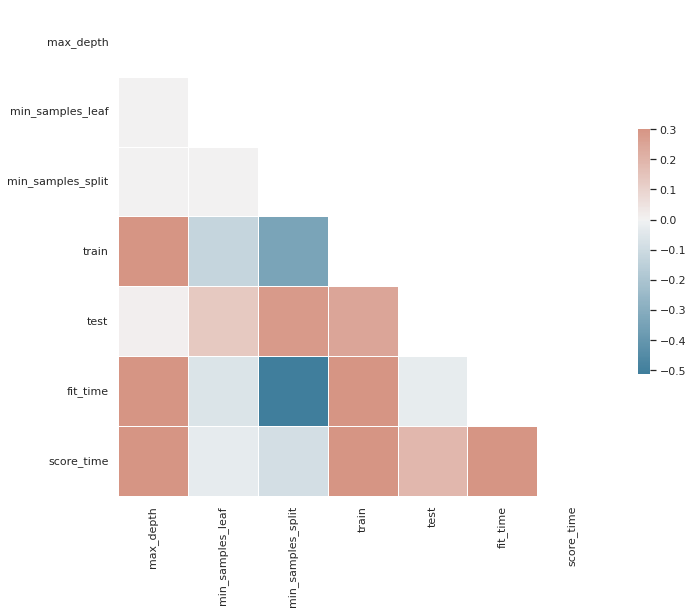

In [33]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = resultados.corr()
sns.set_theme(style="white")


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.011751,0.002370
48,4,32,32,78.750993,78.672633,0.011637,0.001446
34,3,128,32,78.750993,78.672633,0.009650,0.001393
35,3,256,32,78.750993,78.672633,0.009656,0.001391
36,3,32,64,78.750993,78.672633,0.009610,0.001417


# Explorando espaço de hiper parâmetroscom GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth": [3, 4],
    "min_samples_split": [64, 128, 256],
    "min_samples_leaf": [64, 128, 256],
    "criterion": ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)

resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010260,0.000969,0.001582,0.000153,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010138,0.000179,0.001623,0.000089,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.010338,0.000328,0.001777,0.000199,gini,3,64,256,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.009936,0.000184,0.001593,0.000067,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.009709,0.000068,0.001563,0.000121,gini,3,128,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [51]:
melhor_estimator = busca.best_estimator_
melhor_params = busca.best_params_

In [52]:
busca.best_score_*100

78.67263337284332

In [56]:
from sklearn.metrics import accuracy_score
predicoes = melhor_estimator.predict(x_azar)
accuracy= accuracy_score(predicoes, y_azar) * 100
print("Accuracy para dados foi %.2f%%" % accuracy)

Accuracy para dados foi 78.75%
